In [1]:
from graph_tool.all import *
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

# import geopandas as gpd
import pandas as pd
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6nf_nn38 because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# graph_household=load_graph('files/graph_weekday_household_all.xml.gz')

In [3]:
# Juste besoin du graph_overall_dflt2 à ce niveau puisqu'on laisse tomber la variabilité temporelle 
# graph_overall_dflt=load_graph('files/graphs/contact_network1.xml.gz')

In [4]:
graph_overall_dflt2=load_graph('files/graphs/contact_network_22_8_2022.xml.gz')

In [5]:
print('Average number of contacts is {}'.format(np.round(graph_overall_dflt2.num_edges()*2/graph_overall_dflt2.num_vertices(), 3)))

Average number of contacts is 9.999


In [6]:
# trick for multiple-source BFS sampling

# ref of the origin vertex
#source=graph_overall_dflt2.get_vertices()[-1]+1

# random sampling of vertices (n=1000)
# I create the 1000-related virtual edges

#msn=500
#graph_overall_dflt2.add_edge_list([(source, k) for k in np.random.randint(0, graph_overall_dflt2.num_vertices(), msn)])
#graph_overall_dflt2.remove_vertex(11755775)

In [9]:
graph_overall_dflt2.vp

{'age': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7fa3103be070, at 0x7fa3103c6ca0>, 'insee': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7fa3103be070, at 0x7fa3103c6e50>, 'all_neighbours': <VertexPropertyMap object with value type 'bool', for Graph 0x7fa3103be070, at 0x7fa2dcc90be0>, 'keep': <VertexPropertyMap object with value type 'bool', for Graph 0x7fa3103be070, at 0x7fa3103b9f10>}

In [8]:
#graph_household.vp['keep'] = graph_household.new_vp('bool', vals=None, val=False)
graph_overall_dflt2.vp['keep'] = graph_overall_dflt2.new_vp('bool', vals=None, val=False)

In [10]:
graph_overall_dflt2.vp['id'] = graph_overall_dflt2.new_vp('int', vals=graph_overall_dflt2.get_vertices())

In [8]:
#u=GraphView(graph_overall, vfilt= (graph_overall.get_total_degrees(graph_overall.get_vertices())>0))
#graph_overall_without_group0 = Graph(u, prune=True)

In [9]:
len(graph_overall_dflt2.vp['keep'].a)

11755776

In [5]:
#del graph_overall.ep["keep"] 

In [7]:
sampling_rate=30/100
sampling_rate_SP=1/1000000
sampling_rate/sampling_rate_SP-1


def sample_NEW(graph_overall):

    # BFS sampling
    for k in graph_overall.get_vertices():
        graph_overall.vp.keep[k] = False
        
    print("ok")

    # bfs sampling
    list_of_nmasked_vertices=[]

    cpt=0
    n=1000000

    # start with the most connected individual
    #random_node=np.argmax(graph_overall.get_total_degrees(graph_overall.get_vertices())) # workers are over-represented
    #random_node=np.random.randint(0,graph_overall.num_vertices(),1)[0]
    # random_node=10
    
    
    sampling_rate=30/100
    sampling_rate_SP=1/1000000
    number_of_nodes=np.int64(graph_overall.num_vertices()*sampling_rate_SP)
    iterator_sp=np.random.randint(0,graph_overall.num_vertices(), number_of_nodes)

    with tqdm(total=len(iterator_sp), position=0, leave=True) as pbar:
        for sp in iterator_sp:
            list_of_nmasked_vertices.append(graph_overall.vertex(sp))
            for e in bfs_iterator(graph_overall, graph_overall.vertex(sp), array=False):
                #print('bfs iteration {}'.format(cpt))
                if e.target() not in list_of_nmasked_vertices: 
                    list_of_nmasked_vertices.append(e.target())
                    cpt+=1
                    if cpt>(sampling_rate/sampling_rate_SP-1):
                        break
            cpt=0
            pbar.update(1)

    #for k in list_of_nmasked_vertices:
    #    graph_overall.vp.keep[k] = True
    
    return list_of_nmasked_vertices


In [11]:
def sample(graph_overall, random_node):
    graph_overall.vp['keep'].a=False
    graph_overall.vp['all_neighbours'].a=False

    # BFS sampling
    #for k in graph_overall.get_vertices():
    #    graph_overall.vp.keep[k] = False
        
    # print('ok')

    # bfs sampling
    list_of_nmasked_vertices=[]
    list_of_nmasked_vertices_neighbours=[]

    cpt=0
    n=50

    # start with the most connected individual
    #random_node=np.argmax(graph_overall.get_total_degrees(graph_overall.get_vertices())) # workers are over-represented
    
    #random_node=np.random.randint(0,graph_overall.num_vertices(),1)[0]
    # random_node=10
    
    ref=source
    with tqdm(total=int(graph_overall.num_vertices()/n), position=0, leave=True) as pbar: 
        list_of_nmasked_vertices.append(graph_overall.vertex(random_node))
        for e in bfs_iterator(graph_overall, graph_overall.vertex(random_node), array=False):
#             if e.target()!=random_node:
#                 list_of_nmasked_vertices.append(e.target())
            list_of_nmasked_vertices.append(e.target())
    
            if e.source()!=ref: # once all person's neighbors are visited, I store the person as we have all his contacts
                list_of_nmasked_vertices_neighbours.append(ref)
                ref=e.source()
            
            if cpt>int(graph_overall.num_vertices()/n):
                break
                
            
            cpt+=1
            pbar.update(1)
            


    #len(list_of_nmasked_vertices)

    for k in list_of_nmasked_vertices:
        graph_overall.vp.keep[k] = True
        
    for k in list_of_nmasked_vertices_neighbours:
        graph_overall.vp['all_neighbours'][k] = True
    
    return graph_overall


source=np.random.randint(0,graph_overall_dflt2.num_vertices(),1)[0]
graph_overall_dflt2.vp['all_neighbours'] = graph_overall_dflt2.new_vp('bool', vals=None, val=False)


graph_overall1=sample(graph_overall_dflt2, source)
ug = GraphView(graph_overall1, vfilt= (graph_overall1.vp['keep'].a==True))
sub_graph_overall2 = Graph(ug, prune=True)

f=np.argwhere(sub_graph_overall2.vp['all_neighbours'].a==True).reshape(-1)

sub_graph_overall2.get_total_degrees(f).mean()

235170it [00:01, 204699.00it/s]                            


16.17665144061841

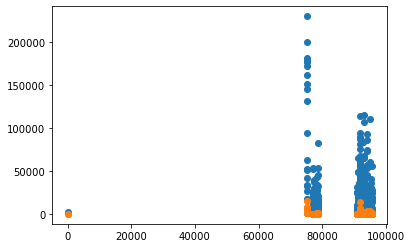

In [28]:
a,b=np.unique(ug.vp['insee'].a, return_counts=True)
plt.plot(a,b, 'o')

a,b=np.unique(sub_graph_overall2.vp['insee'].a, return_counts=True)
plt.plot(a,b, 'o')

In [10]:
#sample_NEW(graph_overall)

In [11]:
#list(graph_overall.vertex(10).out_neighbors())

# label sampled nodes
#for k in list_of_nmasked_vertices:
#    graph_overall.vp.keep[k] = True
    #graph_household.vp.keep[k] = True

In [12]:
# # random sampling
# for k in graph_overall.get_vertices():
#     graph_overall.vp.keep[k] = False
    
# print('sampling ...')

# for k in np.random.choice(np.arange(int(graph_overall.num_vertices())), size=int(graph_overall.num_vertices()), replace=False):
#     graph_overall.vp.keep[k] = True
    
# print('completed')

In [13]:
# graph_overall.get_total_degrees(graph_overall.get_vertices())>0

In [14]:
# u=8288023
# v=8434576
# graph_overall.edge(u, v, all_edges=True)
# print(graph_overall.vp.keep[list_of_nmasked_vertices[2]])

In [15]:
#ug = GraphView(graph_overall1, vfilt= (graph_overall1.vp['keep'].a==True))
#sub_graph_overall2 = Graph(ug, prune=True)

In [16]:
# keep sampled individuals
#ug1 = GraphView(graph_overall1, vfilt= (graph_overall1.vp['keep'].a==True))#, efilt= (graph_overall1.ep['purpose'].a!=6))
#sub_ug1 = Graph(ug1, prune=True)

# # keep non_HH contacts only
# sug1 = GraphView(sub_ug1, efilt= (sub_ug1.ep['purpose'].a!=6))
# sub_graph_overall1 = Graph(sug1, prune=True)

In [12]:
# save csv file with sampled persons ids
import os.path

if not os.path.exists('sampled.csv'):
    pd.DataFrame({'person_id': sub_graph_overall2.vp['id'].a, 
                  'full_contacts': sub_graph_overall2.vp['all_neighbours'].a}).to_csv('sampled.csv', index=False)
    #ug.save('sampled_contact_network.xml.gz')
    sub_graph_overall2.save('sampled_contact_network_26_09_2022.xml.gz')
else:
    print('File already exists !')

In [15]:
source

2604967

In [20]:
sum(sub_graph_overall2.vp.id.a==source)

1

In [35]:
# Additional codes

u=sub_graph_overall2.vp['id'].a[sub_graph_overall2.get_edges()[:,0]]
v=sub_graph_overall2.vp['id'].a[sub_graph_overall2.get_edges()[:,1]]

In [38]:
df=pd.DataFrame({'idu': u, 
              'idv': v, 
              'duration': sub_graph_overall2.ep['duration'].a, 
              'purpose': sub_graph_overall2.ep['purpose'].a,
              'location': sub_graph_overall2.ep['p'].a})

In [42]:
df.to_csv('contacts.csv', index=False)

In [26]:
print(ug.num_vertices())
print(ug.num_edges())

117560
665294


In [461]:
#len(GraphView(graph_overall1, vfilt= (graph_overall1.vp['keep'].a==True), efilt= (graph_overall1.ep['purpose'].a!=6)).get_edges())

201981

In [18]:
np.unique(graph_overall1.ep['purpose'].a, return_counts=True)

(PropertyArray([0, 1, 2, 3, 4, 6], dtype=int32),
 array([12208580,  7938237, 23530004,   491692,  2221651, 12388619]))

In [19]:
# sub_graph_overall_without_group0.get_total_degrees(sub_graph_overall_without_group0.get_vertices()).max()

In [20]:
#u = GraphView(graph_household, vfilt= (graph_household.vp['keep'].a==1))
#sub_graph_household = Graph(u, prune=True)

In [21]:
#sub_graph_household.num_vertices()

In [22]:
graph_overall1.num_edges()*2/graph_overall1.num_vertices()

9.999983497473922

In [24]:
sub_graph_overall2.num_edges()*2/sub_graph_overall2.num_vertices()

13.715260292616536

In [25]:
# sub_graph_overall_without_group0.num_edges()*2/sub_graph_overall_without_group0.num_vertices()

In [26]:
#graph_draw(sub_graph_overall)

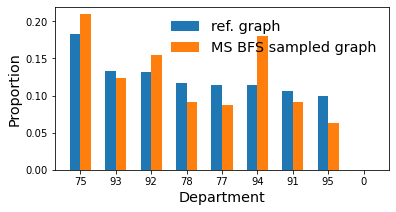

In [23]:
#graph_overall_dflt2.remove_vertex(source)



fig, ax=plt.subplots(figsize=(6, 3))
df1=pd.DataFrame(graph_overall1.vp['dep'].a).value_counts()/graph_overall1.num_vertices()
df2=pd.DataFrame(sub_graph_overall2.vp['dep'].a).value_counts()/sub_graph_overall2.num_vertices()


df3=df1.to_frame('dflt').join(df2.to_frame('sample'))

width=0.3
ax.bar(np.arange(len(df3.index))-width/2, df3['dflt'].values, width=width, label='ref. graph')
ax.bar(np.arange(len(df3.index))+width/2, df3['sample'].values, width=width, label='MS BFS sampled graph')
#fig.savefig('files/validation_{}.jpg'.format(5), bbox_inches='tight', dpi=300)

ax.set_xticks(np.arange(len(df3.index)))
ax.set_xticklabels([k[0] for k in df3.index])

ax.set_xlabel('Department', fontsize='x-large')
ax.set_ylabel('Proportion', fontsize='x-large')

ax.legend(fontsize='x-large', frameon=False)

fig.savefig('files/validation_{}.jpg'.format(5), bbox_inches='tight', dpi=300)
plt.show()

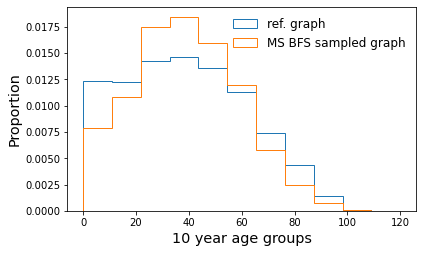

In [24]:
scale=1.25
fig, ax=plt.subplots(figsize=(5*scale, 3*scale))

bins=np.linspace(0, 120, 12)

ax.hist(graph_overall_dflt2.vp['age'].a, bins, density=True, alpha=1., label='ref. graph', histtype='step')
ax.hist(sub_graph_overall2.vp['age'].a, bins, density=True, alpha=1., label='MS BFS sampled graph', histtype='step')
ax.legend(fontsize='large', frameon=False)

ax.set_xlabel('10 year age groups', fontsize='x-large')
ax.set_ylabel('Proportion', fontsize='x-large')

fig.savefig('files/validation_{}.jpg'.format(7), bbox_inches='tight', dpi=300)

plt.show()

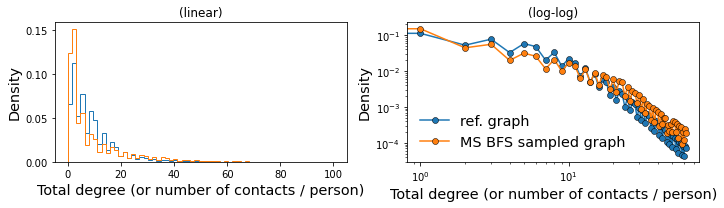

In [25]:
fig, (ax1, ax2)=plt.subplots(figsize=(2*5, 3), ncols=2, tight_layout=True)

bins=np.linspace(0, 100, 2**6)

ddp1=ax1.hist(graph_overall_dflt2.get_total_degrees(graph_overall_dflt2.get_vertices()),bins, density=True, alpha=1., histtype='step')[0]
ddp2=ax1.hist(sub_graph_overall2.get_total_degrees(sub_graph_overall2.get_vertices()),bins, density=True, alpha=1., histtype='step')[0]
#ax1.set_xlim(0, 100)

ax2.loglog(ddp1,'-o', label='ref. graph', alpha=1., mec='k', mew=0.5)
ax2.loglog(ddp2,'-o', label='MS BFS sampled graph', alpha=1., mec='k', mew=0.5)
ax2.legend(fontsize='x-large', frameon=False)

ax1.set_xlabel('Total degree (or number of contacts / person)', fontsize='x-large')
ax1.set_ylabel('Density', fontsize='x-large')

ax2.set_xlabel('Total degree (or number of contacts / person)', fontsize='x-large')
ax2.set_ylabel('Density', fontsize='x-large')

#ax1.grid(True, lw=0.1)
#ax2.grid(True, lw=0.1)

ax1.set_title('(linear)')
ax2.set_title('(log-log)')

fig.savefig('files/validation_{}.jpg'.format(6), bbox_inches='tight', dpi=300)


In [83]:
#sub_graph_overall.save("files/sub_graph_weekday_nhousehold_all.xml.gz")
#sub_graph_household.save("files/sub_graph_weekday_household_all.xml.gz")

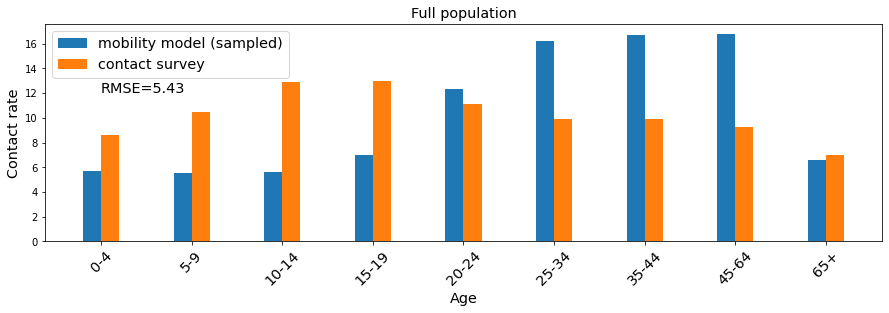

In [30]:
def get_rmse(pred, obs):
    return np.round(np.sqrt(((pred-obs)**2).sum()/len(pred)),2)

# get id's of persons conditioned on age

mnrc=[]

for u,v in zip([0, 5, 10, 15, 20, 25, 35, 45, 65], [5, 10, 15, 20, 25, 35, 45, 65, 120]):
    f=np.asarray((sub_graph_overall2.vp['age'].a>=u)&(sub_graph_overall2.vp['age'].a<v))
    f=sub_graph_overall2.get_vertices()[f]
    #print('{}-{} - {}'.format(u,v, 1*np.round(graph_overall.get_total_degrees(f).mean(), 2)))
    mnrc.append(np.round(sub_graph_overall2.get_total_degrees(f).mean(), 2))

size=2.
fig, ax=plt.subplots(figsize=(7.5*size,2.*size))


n=0
data=np.array([8.64, 10.5, 12.92, 12.96, 11.14, 9.95, 9.93, 9.24, 7.01])
#data=data/data[n]

std=np.asarray(mnrc)
#std=std/std[n]


width=0.2
ax.bar(np.arange(len(mnrc))- width/2, std, width=width, label='mobility model (sampled)')
ax.bar(np.arange(len(mnrc))+ width/2, data, width=width, label='contact survey')
ax.legend(fontsize='x-large', loc='best')
#ax.grid(True, lw=0.1)
#ax.set_yticks(np.arange(4)/2)
ax.set_xlabel('Age',fontsize='x-large')
ax.set_ylabel('Contact rate',fontsize='x-large')
ax.set_xticks(np.arange(9))
ax.set_xticklabels(['0-4', '5-9', '10-14', '15-19', '20-24', '25-34', '35-44', '45-64', '65+'], rotation=45, fontsize='x-large')
# ax.axhline(y=10., color='red', lw=0.1)
ax.set_title('Full population', fontsize='x-large')
ax.text(0, 12, 'RMSE='+ str(get_rmse(std, data)), fontsize='x-large')

#fig.savefig('files/graphs/contacts_by_age-ref.jpg', bbox_inches='tight', dpi=300)

plt.show()

In [256]:
# save BFS sampled contact network

#sub_graph_overall2.save("files/graphs/contact_network2_BFSsampled_5pc.xml.gz")

In [31]:
# toy graph

# g = load_graph("search_example.xml")
# name = g.vp["name"]
# weight = g.ep["weight"]
# pos = g.vp["pos"]
# graph_draw(g, pos, vertex_text=name, vertex_font_size=12, vertex_shape="double_circle",
#               vertex_fill_color="#729fcf", vertex_pen_width=3,
#               edge_pen_width=weight)

In [32]:
# class VisitorExample(BFSVisitor):

#     def __init__(self, name, pred, dist):
#         self.name = name
#         self.pred = pred
#         self.dist = dist

#     def discover_vertex(self, u):
#         print("-->", self.name[u], "has been discovered!")

#     #def examine_vertex(self, u):
#     #    print(self.name[u], "has been examined...")
    
#     def finish_vertex(self,u):
#         print(self.name[u], 'completed !')

#     def tree_edge(self, e):
#         self.pred[e.target()] = int(e.source())
#         self.dist[e.target()] = self.dist[e.source()] + 1
        
# dist = g.new_vertex_property("int")
# pred = g.new_vertex_property("int64_t")
# bfs_search(g, g.vertex(0), VisitorExample(name, pred, dist))

In [465]:
# from numba import njit, prange

# @njit(fastmath=True, parallel=False)
# def isin2(value, array):

    
#     flag=False

#     for i in prange(array.shape[0]):
#         if array[i,0]==value[0] and array[i,1]==value[1]:
#             flag= True
            
#         if array[i,0]==value[1] and array[i,1]==value[0]:
#             flag= True

#     return flag

# @njit(fastmath=True)
# def isin(value, A):
#     return len(np.where((A-value).sum(axis=1)==0)[0])>0


# @njit(fastmath=True)
# def isin3(value, A):
#     return (~np.all(A- value, 1)).sum()>0


# def isin4(value, A):
#     return value in list(A)

In [33]:
# start_time = time.time()
# isin(np.array([ 51027, -1]), unique_pairs)
# print("--- %s seconds ---" % (time.time() - start_time))


# start_time = time.time()
# isin2(np.array([ 51027, -1]), unique_pairs)
# print("--- %s seconds ---" % (time.time() - start_time))


# start_time = time.time()
# isin4(( 51027, -1), A_tuples)
# print("--- %s seconds ---" % (time.time() - start_time))

# #start_time = time.time()
# #isin3(np.array([ 51027, 227751]), unique_pairs)
# #print("--- %s seconds ---" % (time.time() - start_time))

In [34]:
# from numba import njit



# def filter_by_location(np_array):
    
#     # Sort input array test w.r.t. first column that are IDs
#     test_sorted = np_array[np_array[:,1].argsort()]

#     # Convert the string IDs to numeric IDs
#     locations = np.unique(test_sorted[:,1], return_inverse=False)
#     # print('shape of numeric_ID {}'.format(numeric_ID.shape))

#     # Get the indices where shifts (IDs change) occur
#     _,cut_idx = np.unique(test_sorted[:,1],return_index=True)

#     # Use the indices to split the input array into sub-arrays with common IDs
#     return np.split(test_sorted,cut_idx)[1:]

# @njit
# def check_intersections(test_case, purpose=None, odp=None):
    
#     # ID - LOCATION - START TIME - END TIME / PURPOSE
    
#     edge_list=[]
#     act=np.array([[0,  3,  4],
#                   [3,  1,  5],
#                   [4,  5,  2]])
        
#     for i in range(test_case.shape[0]-1): # loop through the activty-travel diaries
#         row=test_case[i]
#         pu=purpose[i] # origin
        
#         rem=test_case[(i+1):]
        
#         for k, pv in zip(rem, purpose[(i+1):]):  
#             if k[0]!=row[0]: # if individuals are different
                
#                 tp=np.array([k[0], row[0]])
                    
#                 if isin2(tp, odp)==False:
#                     break
                    
#                 if row[-1]<=k[2]: # no intersection
#                     break
                    
#                 if pu>2:
#                     pu=2
                
#                 if pv>2:
#                     pv=2
                    
#                 if row[-1]<k[-1]:
#                     d=row[-1]-k[2]
#                 else:
#                     d=k[-1]-k[2]

#                 edge_list.append((row[0], k[0], d, act[pu, pv], row[1]))

#     return edge_list

# @njit
# def check_intersections2(test_case, purpose=None, odp=None):
    
#     # ID - LOCATION - START TIME - END TIME / PURPOSE
    
#     edge_list=[]
#     act=np.array([[0,  3,  4],
#                   [3,  1,  5],
#                   [4,  5,  2]])
        
#     for i in range(test_case.shape[0]-1): # loop through the activty-travel diaries
#         row=test_case[i]
#         pu=purpose[i] # origin
        
#         rem=test_case[(i+1):]
        
#         for k, pv in zip(rem, purpose[(i+1):]):  
#             if k[0]!=row[0]: # if individuals are different
                    
#                 if row[-1]<=k[2]: # no intersection
#                     break
                    
#                 if pu>2:
#                     pu=2
                
#                 if pv>2:
#                     pv=2
                    
#                 if row[-1]<k[-1]:
#                     d=row[-1]-k[2]
#                 else:
#                     d=k[-1]-k[2]

#                 edge_list.append((row[0], k[0], d, act[pu, pv], row[1]))

#     return edge_list

# @njit
# def get_properties_potential_contact_network(test_case, purpose=None):
    
#     # ID - LOCATION - START TIME - END TIME / PURPOSE
     
#     act=np.zeros((3, 3))
#     number_of_contacts_per_location=0
        
#     for i in range(test_case.shape[0]-1): # loop through the activty-travel diaries
#         row=test_case[i]
#         pu=purpose[i] # origin
        
#         rem=test_case[(i+1):]
        
#         for k, pv in zip(rem, purpose[(i+1):]):  
#             if k[0]!=row[0]: # if individuals are different
                
#                 if row[-1]<=k[2]: # no intersection
#                     break
#                 else:
#                     if pu>2:
#                         pu=2
                
#                     if pv>2:
#                         pv=2
#                     act[pu, pv]+=1
#                     number_of_contacts_per_location+=1

#     return act, number_of_contacts_per_location

# # @njit
# # def get_updated_contacts(od_pairs, travel_diaries, purpose):
# #     # od_pairs ==> (u,v)
# #     # travel_diaries ==> id, loc_id, st, ed
# #     list_of_new_contacts=[]

    
# #     for k in od_pairs:
# #         u, v= k[0], k[1]
# #         fu=np.where(travel_diaries[:,0]==u)[0]
# #         fv=np.where(travel_diaries[:,0]==v)[0]
# #         fstacked=np.hstack((fu,fv))
# #         fo=check_intersections(travel_diaries[fstacked], purpose=purpose[fstacked])
# #         list_of_new_contacts.extend(fo)

        
# #     return list_of_new_contacts

In [35]:
# import time

# f=graph_overall1.get_vertices()[graph_overall1.vp['keep'].a==True]
# df=df_activities[df_activities['person_id_gt'].isin(f)]

# travel_diaries=df[['person_id_gt','location_id','start_time','end_time']].values
# purpose=df['purpose'].values

# unique_pairs=set([(k[0], k[1]) if k[0]<k[1] else (k[1], k[0]) for k in ug1.get_edges()])
# unique_pairs=np.asarray(list(unique_pairs))

In [37]:
# out=filter_by_location(df[['person_id_gt','location_id','start_time','end_time','purpose']].astype(int).values)

In [38]:
# #unique_pairs=np.array([[1,2],[2,3]])
# #travel_diaries=np.array([[1,2,20, 30],[2,2,25,40],[3,2,35,45]])
# #purpose=np.array([1,1,3])

# print('Checking ...')
# sst=time.time()
# # list_of_new_contacts=get_updated_contacts(unique_pairs, travel_diaries, purpose)

# cpt=0
# list_of_new_contacts=[]


# with tqdm(total=len(out), position=0, leave=True) as pbar:    
#     for k in out:
#         if len(np.unique(k[:,0]))>1:
#             ks=k[k[:, 2].argsort()]
#             list_of_new_contacts.extend(check_intersections2(ks[:,0:-1], purpose=ks[:,-1], odp=unique_pairs))
        
#         pbar.update(1)


# print(time.time()-sst)

In [39]:
#print('lack of', ug1.get_edges().shape[0]-(len(list_of_new_contacts)+len(list_of_contacts_in_HH)), 'links')

In [40]:
# ## DATA PRE-PROCESSING

# df_persons=pd.read_csv('data/all/egt/persons.csv',';').drop(['Unnamed: 0'], axis=1)
# df_persons['person_id_gt']=df_persons.index

# df_activities=pd.read_csv('data/all/egt/activities.csv').drop(['Unnamed: 0'], axis=1).rename(columns={'uid':'location_id'})
# df_activities=df_activities[df_activities['purpose']!='home']
# df_activities=df_activities[(~df_activities.start_time.isnull())&(~df_activities.end_time.isnull())]
# df_activities['purpose']=df_activities['purpose'].astype('category').cat.reorder_categories(['work', 'education', 'leisure', 'shop', 'other']).cat.codes
# df_activities=df_activities.merge(df_persons[['person_id_gt', 'person_id','age']], on='person_id') 

In [480]:
#sub_ug1.save("files/graphs/cgraph.graphml")

In [485]:
# df_p.to_csv('pam/examples/pop/ref/persons.csv')
# df.to_csv('pam/examples/pop/ref/activities.csv')

In [484]:
# sub_ug2.save('pam/examples/pop/ref/contact_graph.xml.gz')

In [20]:
unq, cnt=np.unique(ug.ep['purpose'].a, return_counts=True)
print(unq, cnt)

[0 1 2 3 4 6] [12208580  7938237 23530004   491692  2221651 12388619]


In [21]:
pd.DataFrame({'contact_type': unq, 'freq': cnt}).to_csv('contact_freq_sampled_graph.csv')

In [22]:
# load sampled graph, to generate a csv file with contacts, to make the vizualisation maps

#sampled_graph=load_graph('./pam/examples/pop/ref/contact_graph.xml.gz')
sampled_graph=ug

In [23]:
df=pd.DataFrame(sampled_graph.get_edges([sampled_graph.ep['duration'], sampled_graph.ep['purpose']]), columns=['u','v','duration','purpose'])
df.to_csv('contacts_sampled_graph.csv')

In [24]:
# save csv file with sampled persons ids
import os.path

if not os.path.exists('sampled.csv'):
    pd.DataFrame({'person_id': ug.get_vertices()}).to_csv('sampled.csv')
else:
    print('File already exists !')